In [223]:
import ast
import csv
from distutils.log import error 
import json
import math
import numpy as np
import matplotlib.pyplot as plt
import shapely

import led_config_utils
from impossible_dialogue import wavefront, led_config

from importlib import reload
reload(led_config)


class Segment:
    def __init__(self, start, end):
        self.start = np.array(start)
        self.start_str = '{:.3f}, {:.3f}, {:.3f}'.format(
            start[0], start[1], start[2])
        self.end = np.array(end)
        self.end_str = '{:.3f}, {:.3f}, {:.3f}'.format(
            end[0], end[1], end[2])
        self.next = None

    def flip(self):
        self.start, self.end = self.end, self.start
        self.start_str, self.end_str = self.end_str, self.start_str

    def __repr__(self):
        return repr([self.start, self.end])


class Polygon:
    def __init__(self, segments=[]):
        self.vertices = []
        for segment in segments:
            self.vertices.append(segment.start)

    def __repr__(self):
        return repr(self.vertices)

    def to_dict(self):
        return [v.tolist() for v in self.vertices]

class Path:
    def __init__(self, segments=[]):
        self.vertices = []
        for i, segment in enumerate(segments):
            if i == 0:
                self.vertices.append(segment.start)
            self.vertices.append(segment.end)

    def __repr__(self):
        return repr(self.vertices)

def distance(point, other_point):
    return np.linalg.norm(point - other_point)

def create_paths(path_segments, max_distance=0.01):
    segments = [Segment(segment_points[0], segment_points[1]) for segment_points in path_segments]

    paths = []
    while segments:
        path_segments = []
        first_segment = segments.pop()
        last_segment = first_segment
        path_segments.append(first_segment)
        start_new_path = False

        while not start_new_path:
            start_new_path = True
            for segment in segments:
                if distance(last_segment.end, segment.start) <= max_distance:
                    segments.remove(segment)
                    path_segments.append(segment)
                    last_segment = segment
                    start_new_path = False
                    break
                
                if distance(last_segment.end, segment.end) <= max_distance:
                    segments.remove(segment)
                    segment = Segment(segment.end, segment.start)
                    path_segments.append(segment)
                    last_segment = segment
                    start_new_path = False
                    break

                if distance(first_segment.start, segment.end) <= max_distance:
                    segments.remove(segment)
                    path_segments.insert(0, segment)
                    first_segment = segment
                    start_new_path = False
                    break
            
                if distance(first_segment.start, segment.start) <= max_distance:
                    segments.remove(segment)
                    segment = Segment(segment.end, segment.start)
                    path_segments.insert(0, segment)
                    first_segment = segment
                    start_new_path = False
                    break
                
        # print(len(path_segments))
        paths.append(Path(path_segments))

    return paths


def prepare_data(polygons):
    x = np.array([v[0] for p in polygons for v in p.vertices])
    y = np.array([v[1] for p in polygons for v in p.vertices])
    z = np.array([v[2] for p in polygons for v in p.vertices])

    data = np.concatenate((x[:, np.newaxis],
                           y[:, np.newaxis],
                           z[:, np.newaxis]),
                           axis=1)
    return data


def project_point_2d(point, U, mu):
    L = np.dot(point - mu, U.T)
    return np.array([L.T[0], L.T[1]])


def project_polygons_2d(polygons):
    data = prepare_data(polygons)
    Z, U, mu = led_config_utils.pca(data)
    polygons_2d = []
    for p in polygons:
        polygon_2d = Polygon()
        for v in p.vertices:
            vertex_2d = project_point_2d(v, U, mu)
            polygon_2d.vertices.append(vertex_2d)
        polygons_2d.append(polygon_2d)
    return polygons_2d, U, mu


def plot_polygons_2d(polygons_2d):

    # create scatter plot for samples from each cluster
    for polygon in polygons_2d:
        x = [v[0] for v in polygon.vertices] + [polygon.vertices[0][0]]
        y = [v[1] for v in polygon.vertices] + [polygon.vertices[0][1]]
        plt.plot(x, y)

    # plt.axis('scaled')
    # plt.show()
    # plt.rcParams['figure.figsize'] = [25, 5]

def plot_paths(polygons_2d):

    # create scatter plot for samples from each cluster
    for polygon in polygons_2d:
        x = [v[0] for v in polygon.vertices] + [polygon.vertices[0][0]]
        y = [v[1] for v in polygon.vertices] + [polygon.vertices[0][1]]
        plt.plot(x, y)

    # plt.axis('scaled')
    # plt.show()
    # plt.rcParams['figure.figsize'] = [25, 5]


def plot_segment(segment):
    fig = plt.figure()
    x = segment.points_2d[:][:, 0]
    y = segment.points_2d[:][:, 1]
    plt.plot(x, y)

    plt.axis('scaled')
    plt.show()
    plt.rcParams['figure.figsize'] = [25, 5]


def read_line_segments(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        reader = csv.reader(f)
        next(reader)  # skip header

        segments = []
        for row in reader:
            uid = int(row[0])
            name = row[1]
            actual_num_leds = int(row[2])
            actual_length = float(row[3])
            reverse = (row[4] == 'TRUE')
            led_offset = int(row[5])
            sub_component = row[6]
            actual_num_adressable_leds = int(row[7])
            csv_points = ast.literal_eval(row[10])
            
            segment_points = []
            for p in csv_points:
                point = np.array(p)
                point = (point.reshape((3,1))).reshape((1,3))
                point = np.squeeze(np.asarray(point))
                segment_points.append(p)
            segments.append(segment_points)
    
    return segments

def create_polygons_from_segments(segments):
    start_dict = {}
    end_dict = {}
    for segment_points in segments:
        segment = Segment(segment_points[0], segment_points[1])
        if segment.start_str in start_dict:
            segment2 = start_dict[segment.start_str]
            if segment.end_str == segment2.end_str:
                print(f"Ignoring duplicate line segment [[{segment.start_str}], [{segment.end_str}]]")
                continue
            else:
                segment = Segment(segment_points[1], segment_points[0])
                print(
                    f"Flipping line segment [[{segment.start_str}], [{segment.end_str}]]")
        if segment.end_str in end_dict:
            segment2 = end_dict[segment.end_str]
            if segment.start_str == segment2.start_str:
                print(f"Ignoring duplicate line segment [[{segment.start_str}], [{segment.end_str}]]")
                continue
            else:
                segment = Segment(segment_points[1], segment_points[0])
                print(f"Flipping line segment [[{segment.start_str}], [{segment.end_str}]]")
        start_dict[segment.start_str] = segment
        end_dict[segment.end_str] = segment


    polygons = []
    while start_dict:
        polygon_segments = []
        polygon_start_str, segment = start_dict.popitem()
        end_str = '%s' % segment.end_str
        end_dict.pop(end_str)
        polygon_segments.append(segment)
        while end_str != polygon_start_str:
            if end_str in start_dict:
                segment = start_dict.pop(end_str)
                end_str = '%s' % segment.end_str
                end_dict.pop(end_str)
                polygon_segments.append(segment)
            elif end_str in end_dict:
                segment = end_dict.pop(end_str)
                start_dict.pop(segment.start_str)
                segment = Segment(segment.end, segment.start)
                end_str = '%s' % segment.end_str
                polygon_segments.append(segment)
            else:
                print(
                    f"Couldn't find line segment {end_str} to finish polygon.")
                break
        # print(len(polygon_segments))
        polygons.append(Polygon(polygon_segments))

    return polygons


def polygon_index(point_2d, polygons_2d):
    point = shapely.Point(point_2d[0], point_2d[1])
    for i, p in enumerate(polygons_2d):
        polygon = shapely.Polygon([(v[0], v[1]) for v in p.vertices])
        if polygon.contains(point):
            plt.scatter([point_2d[0]], point_2d[1], color=f"C{i}")
            return i
    print(f"ERROR: couldn't find a polygon containing {point_2d}")
    # plt.scatter([point_2d[0]], point_2d[1])

Processing face_front
Flipping line segment [[-0.112, 1.271, 0.489], [-0.096, 1.296, 0.485]]
Flipping line segment [[0.112, 1.271, 0.489], [0.096, 1.296, 0.485]]
Flipping line segment [[-0.332, 0.465, 0.632], [-0.340, 0.465, 0.632]]
Flipping line segment [[0.332, 0.465, 0.632], [0.340, 0.465, 0.632]]
Number of paths: 6
Processing path 0
Number of path points 131
Segment face_0: length=0.1fm, num_leds=131
Processing path 1
Number of path points 131
Segment face_1: length=0.1fm, num_leds=131
Processing path 2
Number of path points 56
Segment face_2: length=0.1fm, num_leds=56
Processing path 3
Number of path points 56
Segment face_3: length=0.1fm, num_leds=56
Processing path 4
Number of path points 26
Segment face_4: length=0.1fm, num_leds=26
Processing path 5
Number of path points 26
Segment face_5: length=0.1fm, num_leds=26


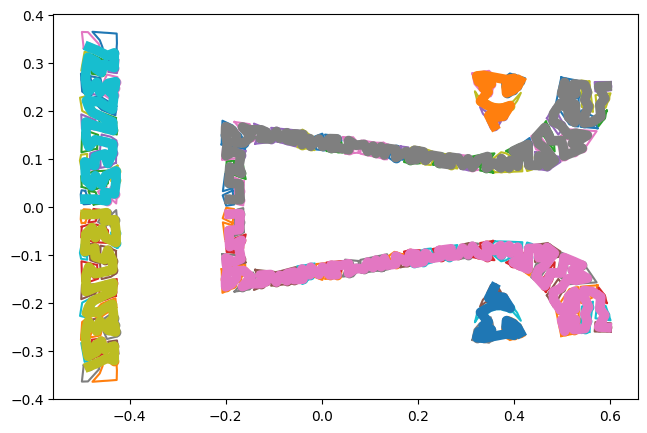

In [224]:

all_segments = {}
all_polygons = []
# for face in ['face_front', 'face_front_right', 'face_front_left']:
for face_index, face in enumerate(['face_front']):
    print(f'Processing {face}')
    polygon_segments = read_line_segments(f'../config/{face}_polygon_line_segments.csv')
    polygons = create_polygons_from_segments(polygon_segments)
    polygons_2d, U, mu = project_polygons_2d(polygons)
    plot_polygons_2d(polygons_2d)
    polygon_index_offset = len(all_polygons)
    all_polygons.extend(polygons)

    path_segments = read_line_segments(f'../config/{face}_led_line_segments.csv')
    paths = create_paths(path_segments)
    print(f"Number of paths: {len(paths)}")
    for path_index, path in enumerate(paths): 
        print(f"Processing path {path_index}")
        points = np.array(path.vertices)
        polygon_indices = []
        points_2d = []
        for point in path.vertices:
            point_2d = project_point_2d(point, U, mu)
            points_2d.append(point_2d)
            index = polygon_index(point_2d, polygons_2d)
            polygon_indices.append(index + polygon_index_offset)

        plt.plot([v[0] for v in points_2d] , [v[1] for v in points_2d], linewidth=7.0)

        polygon_indices = np.array(polygon_indices)
        points_2d = np.array(points_2d)
        if len(points) == 0:
            print('No points available.')
            continue

        print(f"Number of path points {len(points)}")
        # print(f"Polygon indices: {polygon_indices}")
        uid = face_index * 10 + path_index
        name = f"face_{uid}"
        segment = led_config.Segment(uid=uid, name=name, points=points,
                                     num_leds=points.shape[0], length=0, 
                                     polygon_indices=polygon_indices,
                                     points_2d=points_2d)
        print(f'Segment {segment.name}: length={segment.length}.1fm, num_leds={segment.num_leds}')
        segments.append(segment)
        all_segments[name] = segment

plt.axis('scaled')
plt.show()
plt.rcParams['figure.figsize'] = [100, 20]

Segment: mouth, num_points: 112


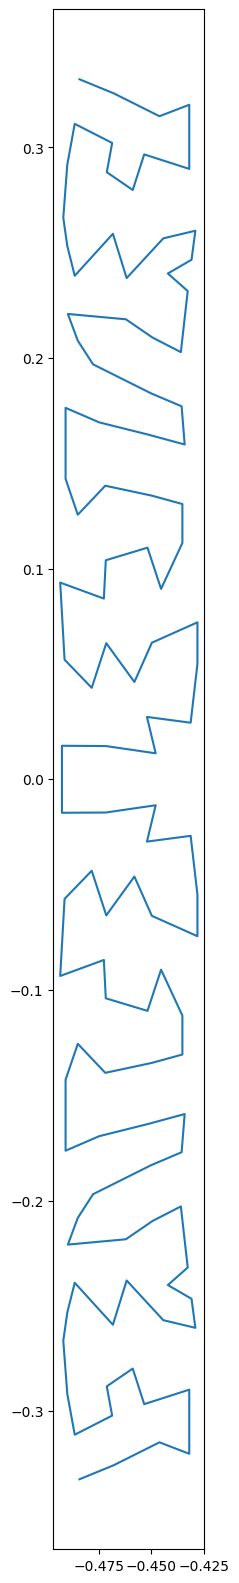

Segment: front_nose_eyes, num_points: 314


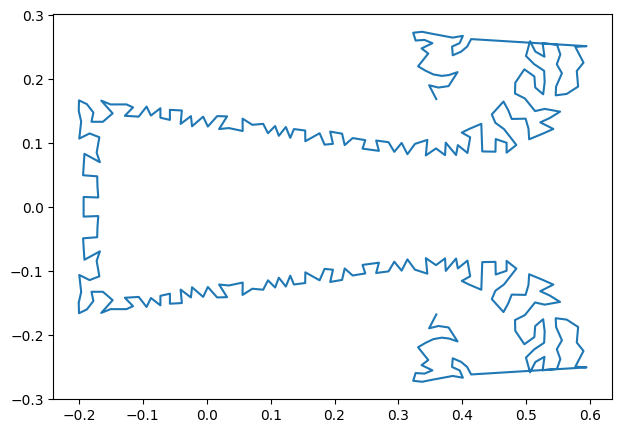

In [225]:
merge_config = [
    ("front_nose_eyes", [("face_4", True), ("face_0", True), ("face_1", False), ("face_5", False)]),
    ("mouth", [("face_2", False), ("face_3", True)])
]

# for merge_list in [SEGMENT_1, SEGMENT_2, SEGMENT_3, SEGMENT_4, SEGMENT_5, SEGMENT_6]:
for merged_name, merge_list in merge_config:
    name1, flip1 = merge_list[0]
    segment1 = all_segments[name1]
    if flip1:
        segment1.flip()
    for name2, flip2 in merge_list[1:]:
        segment2 = all_segments.pop(name2)
        if flip2:
            segment2.flip()
        segment1.merge(segment2)
    segment1.name = merged_name

for segment in all_segments.values():
    print(f"Segment: {segment.name}, num_points: {len(segment.points)}")
    plot_segment(segment)

In [226]:
# Create LED config
config = led_config.LedConfig()
config.polygons = all_polygons
for segment in all_segments.values():
    config.led_segments.append(segment)
    config.total_num_segments += 1
    config.total_length += segment.length
    config.total_num_leds += segment.num_leds

with open('../config/led_config_impossible_dialogue.json', 'w', encoding='utf-8') as f:
    json.dump(config.to_dict(), f, ensure_ascii=False, indent=4)

TypeError: Object of type ndarray is not JSON serializable